In [1]:
import requests
import pandas as pd
import datetime
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import json
%matplotlib inline

### Utility function to get a JSON object response

In [2]:
def getJsonObject(url):

    headers = {'Content-Type': 'application/json'}
    response = requests.get(url, headers=headers)
    jsonObject = {}
    if response.status_code == 200:
        jsonObject = json.loads(response.content.decode('utf-8'))
    return jsonObject

### Function to give the ARIMA forecast for next 10 days

In [3]:
def getArima(confirmed, datetime_series):

    start_date = datetime_series.max()
    td = datetime.datetime.today() - start_date

    try:
        arima = ARIMA(confirmed, order=(5, 1, 0))
        arima = arima.fit(trend='c', full_output=True,
                          disp=True, transparams=False)
        forecast = arima.forecast(steps=(td.days + 10))
        pred = list(forecast[0])
    except:
        pred = [confirmed[-1]] * (td.days + 10)

    return pred

### Function which generates dates of next 10 days given a start date

In [4]:
def getDates(l, start_date):

    prediction_dates = []

    for i in range(l):
        date = start_date + datetime.timedelta(days=1)
        prediction_dates.append(date)
        start_date = date

    return prediction_dates

In [5]:
months = {
    'january': '01',
    'february': '02',
    'march': '03',
    'april': '04',
    'may': '05',
    'june': '06',
    'july': '07',
    'august': '08',
    'september': '09',
    'october': '10',
    'november': '11',
    'december': '12'
}

In [11]:
month_abbr = {
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
}

### Function to plot ARIMA forecast for India as a whole

In [6]:
def getIndiaArima():
    
    # The url used to fetch real-time data for india as a whole
    api_url = 'https://api.covid19india.org/data.json'
    jsonObject = getJsonObject(api_url)

    time_series = jsonObject['cases_time_series']

    confirmed = []
    dates = []
    
    # creating confirmed cases array and dates array
    for i in time_series:
        c = int(i['totalconfirmed'])
        confirmed.append(c)
        d = i['date'].strip().split(' ')
        date = '2020-' + months[d[1].lower()] + '-' + d[0]
        dates.append(date)

    datetime_series = pd.to_datetime(dates, infer_datetime_format=True)
    
    # start of lockdown 1
    l1 = datetime.datetime(2020, 3, 25)
    
    #start of lockdown 2
    l2 = datetime.datetime(2020, 4, 14)
    
    # prediction till date, before first lockdown was imposed
    pred_before = getArima(confirmed[0:55], datetime_series[0:55])
    dates_before = getDates(len(pred_before), l1)
    
    # prediction till date, before second lockdown was imposed
    pred_l1 = getArima(confirmed[0:75], datetime_series[0:75])
    dates_l1 = getDates(len(pred_l1), l2)
    
    # current prediction given all the restrictions
    pred_l2 = getArima(confirmed, datetime_series)
    dates_l2 = getDates(len(pred_l2), datetime_series.max())

    plt.figure(figsize= (15,10))
    plt.xlabel("Dates",fontsize = 20)
    plt.ylabel('Total cases',fontsize = 20)
    plt.title("Predicted Values for the next 10 Days" , fontsize = 20)

    plt.plot_date(y= pred_before,x= dates_before,linestyle ='dashed',color = '#ff9999',label = 'Predicted before lockdown1');
    plt.plot_date(y= pred_l1,x= dates_l1,linestyle ='dashed',color = 'green',label = 'Predicted before lockdown2');
    plt.plot_date(y= pred_l2,x= dates_l2,linestyle ='dashed',color = 'violet',label = 'Current prediction');
    plt.plot_date(y=confirmed,x=datetime_series,linestyle = '-',color = 'blue',label = 'Actual');
    plt.legend();

/home/akash/.local/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/.local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/.local/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/.local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import registe

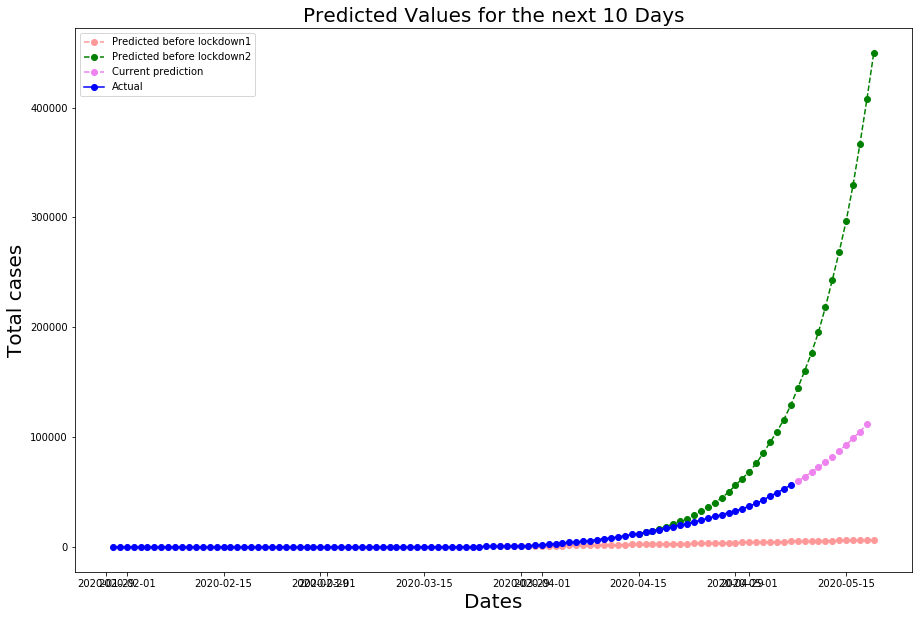

In [7]:
getIndiaArima()

### As we can see from the graph, the number of confirmed cases in India started to show a exponential growth rate around the third week of March. 

### The green line indicates India's condition if lockdown had not been imposed and it is far worse compared to the current scenario

### Although India has done a relatively better job at containing the spread of the virus, the curve has not been flattened yet and is still heading at an exponential rate

#### An utility function to format date

In [12]:
def getDate(s):

    parts = s.split('-')
    date = '2020-' + month_abbr[parts[1]] + '-' + parts[0]
    return date

### Function to Plot the ARIMA chart for a given state

In [13]:
def getStateArima(state):

    temp_state = state.lower()

    api_url = 'https://api.covid19india.org/v2/state_district_wise.json'
    jsonObject = getJsonObject(api_url)

    state_code = ''

    for i in jsonObject:

        if i['state'].lower() == temp_state:
            state_code = i['statecode'].lower()
            break

    confirmed = []
    dates = []
    
    api_url = 'https://api.covid19india.org/states_daily.json'
    jsonObject = getJsonObject(api_url)
    states_daily = jsonObject['states_daily']

    flag = False

    for i in states_daily:
        try:
            if (int(i[state_code]) > 0 or flag) and i['status'] == 'Confirmed':
                flag = True
                dates.append(getDate(i['date']))
                if len(confirmed) > 0:
                    confirmed.append(confirmed[-1] + int(i[state_code]))
                else:
                    confirmed.append(int(i[state_code]))
        except ValueError:
            continue

    datetime_series = pd.to_datetime(dates, infer_datetime_format=True)

    pred = getArima(confirmed, datetime_series)
    dpred = getDates(len(pred), datetime_series.max())
    
    plt.figure(figsize= (15,10))
    plt.xlabel("Dates",fontsize = 20)
    plt.ylabel('Total cases',fontsize = 20)
    plt.title("Predicted Values for the next 10 Days" , fontsize = 20)

    plt.plot_date(y= pred,x= dpred,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
    plt.plot_date(y=confirmed,x=datetime_series,linestyle = '-',color = 'blue',label = 'Actual');
    plt.legend();

#### Plot for Tamil Nadu

/home/akash/.local/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


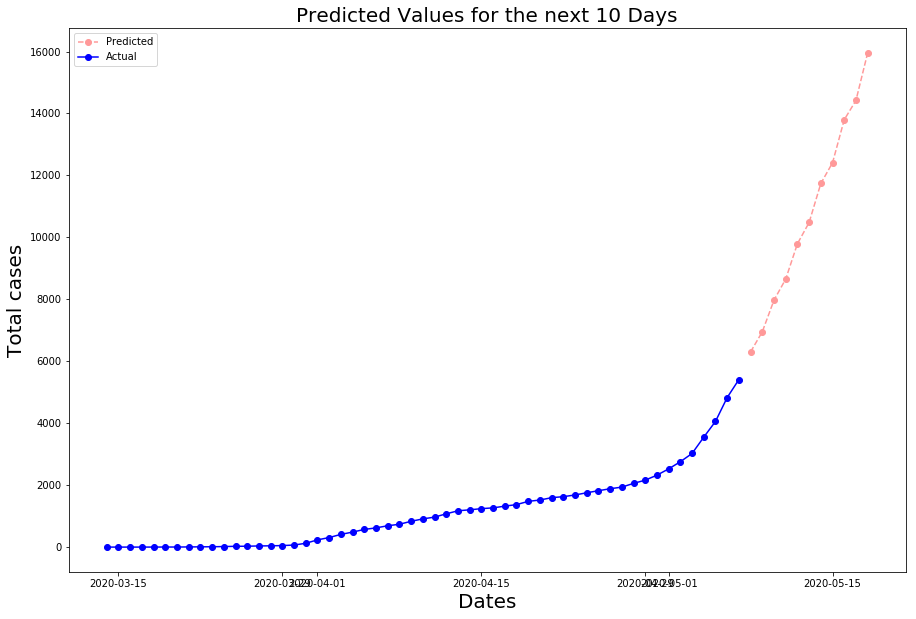

In [14]:
getStateArima('Tamil Nadu')

#### Plot for Maharashtra

/home/akash/.local/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


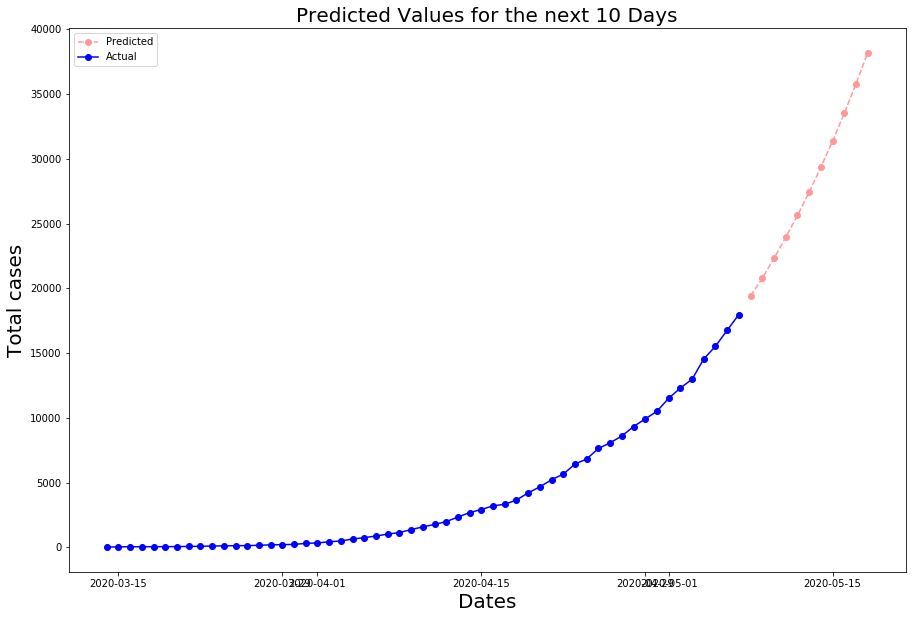

In [15]:
getStateArima('Maharashtra')

### As we can see from the above plots, the rate at which the virus spreads is still exponential in those states

#### Plot for kerala

/home/akash/.local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


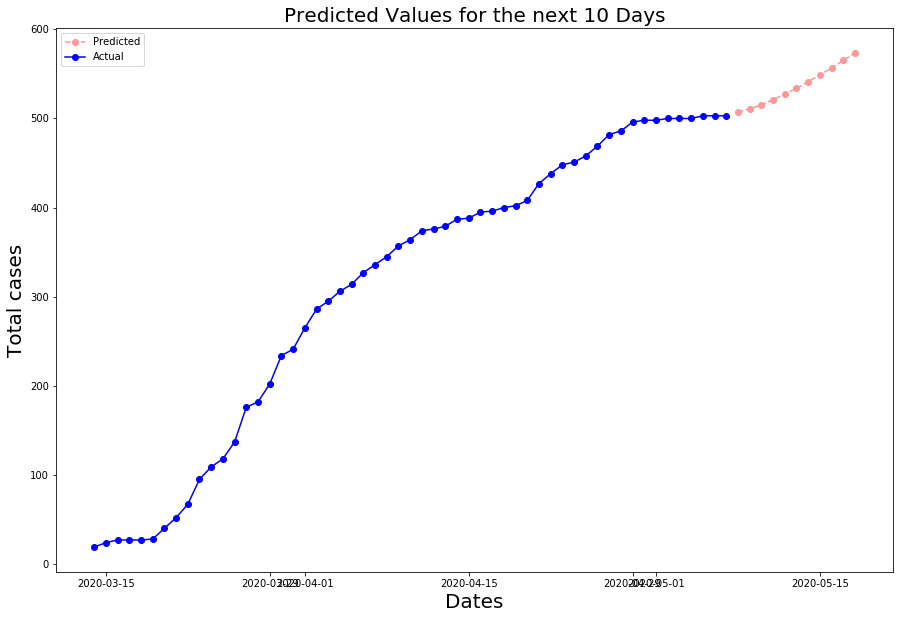

In [16]:
getStateArima('Kerala')

### Kerala has managed to flatten to the curve as we can see in the plot. The predicted values are just a worst case depiction of what could happen but this is to be taken with caution.